In [18]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Load & preprocess
os.chdir('..')
NeuroCurveOG = pd.read_csv("CSV/alzheimers_disease_data.csv")

def pre_process():
    usableCSV = NeuroCurveOG.drop(columns=[
        "PatientID", "CardiovascularDisease", "DoctorInCharge", "Depression",
        "SystolicBP", "DiastolicBP", "Ethnicity", "Gender", "Confusion", "PersonalityChanges",
        "Forgetfulness", "DifficultyCompletingTasks", "Disorientation", "Hypertension",
        "HeadInjury", "Diabetes", "Smoking"
    ])
    usableCSV.to_csv('CSV/output_CSVs/processed.csv', index=False)

pre_process()

usableCSV = pd.read_csv('CSV/output_CSVs/processed.csv')
os.chdir('NeuroPy')

# Step 2: Features and labels
X = usableCSV.drop(columns=['Diagnosis'])
y = usableCSV['Diagnosis'].values

# Step 3: Encode categorical
X['FamilyHistoryAlzheimers'] = X['FamilyHistoryAlzheimers'].astype('category')
X = pd.get_dummies(X, drop_first=True)

# Step 4: Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Step 6: Define model
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

model = NeuralNet(X_train.shape[1])

# Step 7: Loss & optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Step 8: Training loop
for epoch in range(100):
    model.train()
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/100, Loss: {loss.item():.4f}")

# Step 9: Evaluation
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor)
    preds_class = (preds >= 0.5).float()
    accuracy = (preds_class == y_test_tensor).float().mean()
    print(f"\nTest Accuracy: {accuracy:.4f}")


Epoch 10/100, Loss: 0.4333
Epoch 20/100, Loss: 0.2001
Epoch 30/100, Loss: 0.1988
Epoch 40/100, Loss: 0.5538
Epoch 50/100, Loss: 0.4903
Epoch 60/100, Loss: 0.2706
Epoch 70/100, Loss: 0.1735
Epoch 80/100, Loss: 0.2507
Epoch 90/100, Loss: 0.2591
Epoch 100/100, Loss: 0.1166

Test Accuracy: 0.8419


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


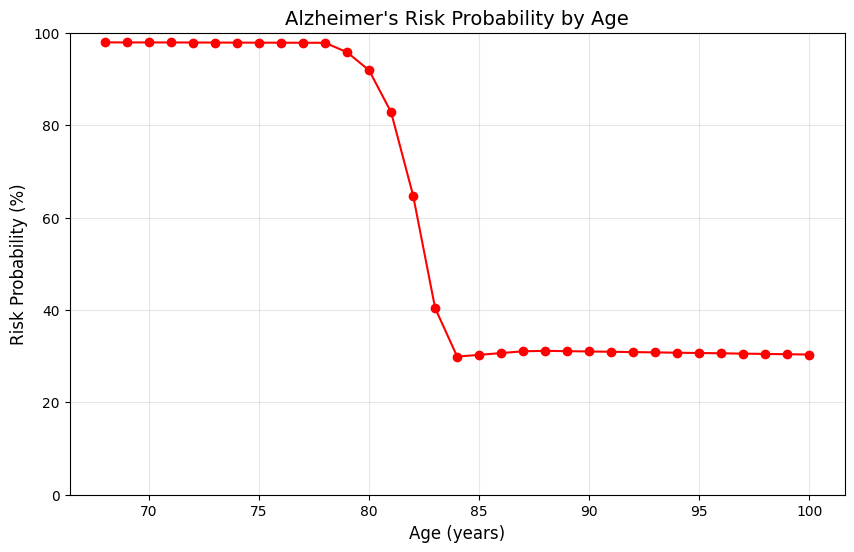

In [27]:
import matplotlib.pyplot as plt

def generate_age_risk(sample: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a DataFrame for one patient, iterating their age from 10 years prior to 100,
    updating 'Age' and incrementing 'FunctionalAssessment' by +1 when age exceeds original,
    while keeping other features constant. Caps FunctionalAssessment at 10.
    """
    original_age = sample["Age"].iloc[0]
    original_functional = sample["FunctionalAssessment"].iloc[0]
    start_age = max(0, original_age - 10)
    ages = np.arange(start_age, 101, 1)
    result_rows = []
    max_score = 10  # Define the maximum score

    for age in ages:
        new_row = sample.copy()
        new_row["Age"] = age
        if age > original_age:
            # Calculate potential new score and cap at max_score
            potential_score = original_functional + (age - original_age)
            new_row["FunctionalAssessment"] = min(potential_score, max_score)
        result_rows.append(new_row)

    return pd.concat(result_rows, ignore_index=True)

def plot_risk_over_age(model, age_variants_df):
    """
    Plots predicted risk probability vs. age for a given patient using the PyTorch model.
    
    Args:
        model: Trained PyTorch neural network
        age_variants_df: DataFrame with patient features, varying 'Age'
    """
    # Convert to numpy array and scale
    X_pred = age_variants_df.values
    X_pred_scaled = scaler.transform(X_pred)  # Use the same scaler from training
    
    # Convert to tensor
    X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32)
    
    # Get probabilities
    model.eval()
    with torch.no_grad():
        probs = model(X_pred_tensor).numpy()
    
    risk_percent = probs * 100  # Convert to percentage
    
    # Get ages
    ages = age_variants_df["Age"].values
        
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(ages, risk_percent, marker='o', linestyle='-', color='red')
    plt.title("Alzheimer's Risk Probability by Age", fontsize=14)
    plt.xlabel("Age (years)", fontsize=12)
    plt.ylabel("Risk Probability (%)", fontsize=12)
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.show()
        


# Example usage
# Assuming 'X' is your feature DataFrame and 'model' is your trained model
sample_df = X.iloc[[13]]  # Select a single patient (row 10)
patient_age_risk = generate_age_risk(sample_df)
plot_risk_over_age(model, patient_age_risk)

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline

def plot_risk_over_age2(model, age_variants_df, scaler):
    """
    Enhanced version with multiple smoothing options and better visualization.
    """
    # Convert to numpy array and scale
    X_pred = age_variants_df.values
    X_pred_scaled = scaler.transform(X_pred)
    
    # Convert to tensor
    X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32)
    
    # Get probabilities
    model.eval()
    with torch.no_grad():
        probs = model(X_pred_tensor).numpy()
    
    risk_percent = probs * 100
    ages = age_variants_df["Age"].values
    
    # Create figure
    plt.figure(figsize=(12, 7))
    
    # Original data (light)
    plt.scatter(ages, risk_percent, color='red', alpha=0.2, label='Original Data')
    
    # Savitzky-Golay smoothing
    window_size = min(15, len(ages)-1)  # Ensure window is smaller than data length
    if window_size % 2 == 0: window_size -= 1  # Ensure odd number
    smoothed_sg = savgol_filter(risk_percent.flatten(), window_size, 3)
    plt.plot(ages, smoothed_sg, color='#E53935', linewidth=3, label='Smoothed (Savitzky-Golay)')
    
    # Cubic spline interpolation
    cs = CubicSpline(ages, risk_percent.flatten())
    ages_smooth = np.linspace(ages.min(), ages.max(), 200)
    smoothed_cs = cs(ages_smooth)
    plt.plot(ages_smooth, smoothed_cs, '--', color='#7B1FA2', linewidth=2, alpha=0.7, label='Spline Interpolation')
    
    # Styling
    plt.title("Alzheimer's Risk Probability by Age (Smoothed)", fontsize=14)
    plt.xlabel("Age (years)", fontsize=12)
    plt.ylabel("Risk Probability (%)", fontsize=12)
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.gca().set_facecolor('#f5f5f5')
    plt.legend()
    plt.tight_layout()
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


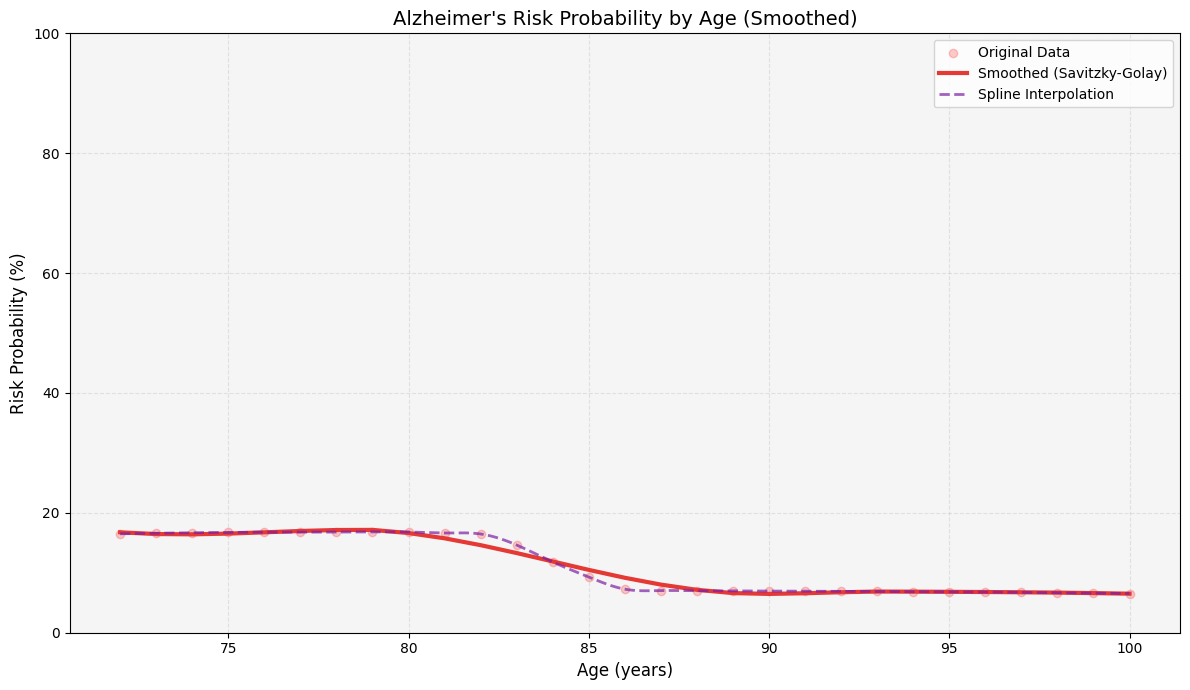

In [39]:
# Assuming you have:
# - model: Your trained PyTorch model
# - X: Your feature DataFrame
# - scaler: The scaler used during training

sample_df = X.iloc[[22]]  # Select patient
patient_age_risk = generate_age_risk(sample_df)
plot_risk_over_age2(model, patient_age_risk, scaler)  # Note the added scaler parameter